# pre

In [2]:
from __future__ import annotations
try:
    from mediocreatbest import auto
except ImportError:
    %pip install --user --upgrade pip
    %pip install --user --upgrade --force-reinstall \
        mediocreatbest
    from mediocreatbest import auto


# lib

In [3]:
%%mediocreatbest.module --reuse mediocreatbest
#@title with_exit_stack

def with_exit_stack(func):
    signature = auto.inspect.signature(func)

    def wrapper(*args, **kwargs):
        with auto.contextlib.ExitStack() as stack:
            if 'stack' in signature.parameters:
                kwargs = kwargs | dict(stack=stack)
            if 'enter' in signature.parameters:
                kwargs = kwargs | dict(enter=stack.enter_context)
            if 'defer' in signature.parameters:
                kwargs = kwargs | dict(defer=stack.callback)

            return func(*args, **kwargs)

    return wrapper


<module 'mediocreatbest' from '/mnt/seenas2/data/home/thobson2/src/GraphShaders2/venv/lib/python3.9/site-packages/mediocreatbest/__init__.py'>

# app

In [53]:
#@title Transpile
def Transpile(
    program: str,
    *,
    files: dict[str, auto.os.PathLike],
    env: dict[str, str],
) -> dict[str, str]:
    with auto.tempfile.TemporaryDirectory() as tempdir:
        tempdir = auto.pathlib.Path(tempdir)
        
        printenv0 = tempdir / 'printenv0'
        printenv0.write_text('#!/usr/bin/env sh\nexec printenv -0')
        printenv0.chmod(0o500)
        
        inpfile = tempdir / 'inpfile'
        inpfile.write_text(program)
        
        args = [
            auto.sys.executable,
            'src/GraphShaderTranspiler.py',
        ] + sum([
            ['-f', str(k), str(v)]
            for k, v in files.items()
        ], []) + sum([
            ['-e', f'{k}', f'{v}']
            for k, v in env.items()
        ], []) + [
            '-i', str(inpfile),
            '-x', str(printenv0),
        ]
        
        stdout = auto.subprocess.check_output(args)
        env = {}
        for line in stdout.split(b'\0'):
            line = line.decode('ascii')
            if line == '':
                continue
            
            try:
                k, v = line.split('=', 1)
            except ValueError:
                print(f'{line=!r}')
                raise
                
            env[k] = v
        
        return env


In [ ]:
#@title GS
@auto.functools.cache
def GS():
    root = auto.pathlib.Path.cwd()

    path = root / 'src'
    if str(path) not in auto.sys.path:
        auto.sys.path.append(str(path))

    path = root / 'stage' / 'lib' / 'libgraphshader.so'
    assert path.exists(), path
    gs = auto.graphshader.GS.load(str(path))
    
    return gs


In [ ]:
#@title Graph
@auto.dataclasses.dataclass
class Graph:
    files: dict[str, auto.pathlib.Path] = auto.dataclasses.field(default_factory=dict)
    datas: dict[str, auto.np.ndarray] = auto.dataclasses.field(default_factory=dict)
    program: str | None = auto.dataclasses.field(default=None)
    size: tuple[
        auto.typing.Annotated[int, 'width'],
        auto.typing.Annotated[int, 'height'],
    ] = auto.dataclasses.field(default=None)
    tile: tuple[
        auto.typing.Annotated[int, 'zoom'],
        auto.typing.Annotated[int, 'row'],
        auto.typing.Annotated[int, 'col'],
    ] = auto.dataclasses.field(default=None)
    verbose: bool | None = auto.dataclasses.field(default=None)
    
    @auto.mediocreatbest.with_exit_stack
    def render(
        self: Self,

        program: str | None = None,

        *,   enter,
        verbose: bool | auto.typing.Literal[...] = ...,

        size: tuple[
            auto.typing.Annotated[int, 'width'],
            auto.typing.Annotated[int, 'height'],
        ] | auto.typing.Literal[...] = ...,
        tile: tuple[
            auto.typing.Annotated[int, 'zoom'],
            auto.typing.Annotated[int, 'row'],
            auto.typing.Annotated[int, 'col'],
        ] | auto.typing.Literal[...] = ...,
        
        outfile: auto.pathlib.Path | auto.typing.Literal[...] = ...,
        tempdir: auto.pathlib.Path | auto.typing.Literal[...] = ...,
    ) -> auto.typing.Annotated[bytes, 'jpeg']:
        if outfile is ...:
            if tempdir is ...:
                tempdir = enter( auto.tempfile.TemporaryDirectory() )
                tempdir = auto.pathlib.Path(tempdir)
            outfile = tempdir / 'outfile.jpg'
        assert outfile is not None

        if program is ...:
            program = self.program
        assert program is not None
        
        if size is ...:
            size = self.size
        assert size is not None
        
        if tile is ...:
            tile = self.tile
        assert tile is not None
        
        if verbose is ...:
            verbose = self.verbose
        assert verbose is not None

        env = Transpile(
            program=program,
            files=self.files,
            env={
                'GS_TILE_WIDTH': size[0],
                'GS_TILE_HEIGHT': size[1],
                'GS_TILE_Z': tile[0],
                'GS_TILE_Y': tile[1],
                'GS_TILE_X': tile[2],
                'GS_OUTPUT': str(outfile),
            },
        )
        
        root = auto.pathlib.Path.cwd()
        path = root / 'stage' / 'bin' / 'GraphShaderEngine'
        
        args = [
            str(path),
        ]

        kwargs = {}
        if not verbose:
            kwargs['stderr'] = auto.subprocess.DEVNULL
            kwargs['stdout'] = auto.subprocess.DEVNULL
        auto.subprocess.check_call(
            args,
            env=env,
            **kwargs,
        )
        
        return outfile.read_bytes()


@auto.IPython.core.magic.register_cell_magic('.render')
def render(line: str, cell: str, /):
    def render(*, graph: Graph, program: str, verbose: bool):
        # auto.pprint.pprint(dict(line=line, cell=cell, graph=graph, program=program))
        image: bytes = graph.render(
            program=program,
            verbose=verbose,
        )
        auto.IPython.display.display(auto.IPython.display.Image(
            image,
        ))

    parser = auto.argparse.ArgumentParser()
    parser.add_argument('--name', '-n', dest='graph', default='graph')
    parser.add_argument('--verbose', '-v', action='store_true')
    parser.set_defaults(program=cell)
    
    args = auto.shlex.split(line)
    args = vars(parser.parse_args(args))
    
    args['graph'] = get_ipython().ev(args.pop('graph'))
    
    render(**args)


# 1st

In [ ]:
def scope():
    import sys
    print(sys.executable)
    print(sys.version)

/scope


/mnt/seenas2/data/home/thobson2/src/GraphShaders2/venv/bin/python
3.9.5 (default, Nov 23 2021, 15:27:38) 
[GCC 9.3.0]


In [3]:
!nvidia-smi | grep Quadro


|   0  Quadro M6000 24GB              On  | 00000000:82:00.0 Off |                  Off |


In [4]:
!./go.sh --Configure


-- Configuring done
-- Generating done
-- Build files have been written to: /home/thobson2/src/GraphShaders2/build
-- Cache values
CMAKE_BUILD_TYPE:STRING=Debug
CMAKE_INSTALL_PREFIX:PATH=/home/thobson2/src/GraphShaders2/stage


In [5]:
!./go.sh --Build


/usr/bin/cmake -S/home/thobson2/src/GraphShaders2 -B/home/thobson2/src/GraphShaders2/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /home/thobson2/src/GraphShaders2/build/CMakeFiles /home/thobson2/src/GraphShaders2/build/CMakeFiles/progress.marks
/usr/bin/make -f CMakeFiles/Makefile2 all
make[1]: Entering directory '/home/thobson2/src/GraphShaders2/build'
/usr/bin/make -f CMakeFiles/graphshader.dir/build.make CMakeFiles/graphshader.dir/depend
/usr/bin/make -f CMakeFiles/GraphShaderEngine.dir/build.make CMakeFiles/GraphShaderEngine.dir/depend
make[2]: Entering directory '/home/thobson2/src/GraphShaders2/build'
cd /home/thobson2/src/GraphShaders2/build && /usr/bin/cmake -E cmake_depends "Unix Makefiles" /home/thobson2/src/GraphShaders2 /home/thobson2/src/GraphShaders2 /home/thobson2/src/GraphShaders2/build /home/thobson2/src/GraphShaders2/build /home/thobson2/src/GraphShaders2/build/CMakeFiles/graphshader.dir/DependInfo.cmake --color=
make[2

In [6]:
!./go.sh --Install


-- Install configuration: "Debug"
-- Up-to-date: /home/thobson2/src/GraphShaders2/stage/bin/GraphShaderEngine
-- Up-to-date: /home/thobson2/src/GraphShaders2/stage/lib/libgraphshader.so
-- Up-to-date: /home/thobson2/src/GraphShaders2/stage/bin/GraphShaderTranspiler.py


# 2nd

In [ ]:
#@title cbf4d9cd
def scope():
    env = Transpile(
        auto.pathlib.Path('examples/JS-Deps/JS-Deps.gsp').read_text(),
        files=dict(
            element="examples/JS-Deps/data/JS-Deps.edge.elements.2u32.bin",
            X      ="examples/JS-Deps/data/JS-Deps.node.x.f32.bin",
            Y      ="examples/JS-Deps/data/JS-Deps.node.y.f32.bin",
            Date   ="examples/JS-Deps/data/JS-Deps.node.date.u32.bin",
            Devs   ="examples/JS-Deps/data/JS-Deps.node.nmaintainers.u32.bin",
            Vuln   ="examples/JS-Deps/data/JS-Deps.node.cve.u32.bin",
        ),
    )

    with auto.mediocreatbest.Textarea():
        print(auto.json.dumps({
            k: v
            for k, v in env.items()
            if k.startswith('GS_')
        }, indent=4))

/scope


os.execlpe('/tmp/tmprag2n6ai/printenv0', '/tmp/tmprag2n6ai/printenv0 <inpfile>', env)


In [13]:
#@title 41c4795e
def scope():
    def scope():
        from mediocreatbest import auto
        
        env = {
            "GS_TILE_HEIGHT": "256",
            "GS_TILE_Z": "0",
            "GS_BUFFER_SIZE_0": "2E",
            "GS_BUFFER_SIZE_1": "N",
            "GS_BUFFER_SIZE_2": "N",
            "GS_BUFFER_SIZE_3": "N",
            "GS_SHADER_GEOMETRY": "\nlayout (lines) in;\nlayout (line_strip, max_vertices=2) out;\n\nlayout(location=0) in uint _fg_NodeIndex[];\n\nlayout(location=0) out flat uint gs_SourceIndex;\nlayout(location=1) out flat uint gs_TargetIndex;\n\nvoid main() {\n    gs_SourceIndex = _fg_NodeIndex[0];\n    gs_TargetIndex = _fg_NodeIndex[1];\n\n    int gs_EdgeIndex = gl_PrimitiveIDIn;\n    vec4 gs_SourcePosition = gl_in[0].gl_Position;\n    vec4 gs_TargetPosition = gl_in[1].gl_Position;\n\n\n    #if USE_RELATIONAL\n    uint od = 1 + atomicAdd(out_degree[gs_SourceIndex], 1);\n    atomicCounterMax(out_degree_max, od);\n\n    uint id = 1 + atomicAdd(in_degree[gs_TargetIndex], 1);\n    atomicCounterMax(in_degree_max, id);\n    #endif /* USE_RELATIONAL */\n\n\n\n    // Apply tile transformations\n    gs_SourcePosition.xy *= uScale;\n    gs_SourcePosition.xy += vec2(uTranslateX, uTranslateY);\n\n    // Transform xy in [0, 1] to xy in [-1, 1]\n    gs_SourcePosition.xy *= 2.;\n    gs_SourcePosition.xy -= 1.;\n\n    // Apply tile transformations\n    gs_TargetPosition.xy *= uScale;\n    gs_TargetPosition.xy += vec2(uTranslateX, uTranslateY);\n\n    // Transform xy in [0, 1] to xy in [-1, 1]\n    gs_TargetPosition.xy *= 2.;\n    gs_TargetPosition.xy -= 1.;\n\n    gl_PrimitiveID = gs_EdgeIndex;\n    gl_Position = gs_SourcePosition;\n    EmitVertex();\n\n    gl_Position = gs_TargetPosition;\n    EmitVertex();\n\n    EndPrimitive();\n}\n    ",
            "GS_BUFFER_SIZE_4": "N",
            "GS_BUFFER_SIZE_5": "N",
            "GS_BUFFER_SIZE_6": "N",
            "GS_BUFFER_TYPE_0": "GL_UNSIGNED_INT",
            "GS_BUFFER_SIZE_7": "N",
            "GS_BUFFER_TYPE_1": "GL_FLOAT",
            "GS_BUFFER_SIZE_8": "E",
            "GS_OUTPUT": "out.jpg",
            "GS_BUFFER_BIND_0": "<NONE>",
            "GS_BUFFER_TYPE_2": "GL_FLOAT",
            "GS_BUFFER_SIZE_9": "48",
            "GS_BUFFER_BIND_1": "0",
            "GS_BUFFER_TYPE_3": "GL_UNSIGNED_INT",
            "GS_BUFFER_BIND_2": "1",
            "GS_BUFFER_TYPE_4": "GL_UNSIGNED_INT",
            "GS_BUFFER_FILE_0": "examples/JS-Deps/data/JS-Deps.edge.elements.2u32.bin",
            "GS_BUFFER_BIND_3": "2",
            "GS_BUFFER_TYPE_5": "GL_UNSIGNED_INT",
            "GS_BUFFER_COUNT": "10",
            "GS_BUFFER_NAME_0": "_ELEMENT",
            "GS_BUFFER_FILE_1": "examples/JS-Deps/data/JS-Deps.node.x.f32.bin",
            "GS_BUFFER_BIND_4": "3",
            "GS_BUFFER_TYPE_6": "GL_UNSIGNED_INT",
            "GS_BUFFER_NAME_1": "_X",
            "GS_BUFFER_FILE_2": "examples/JS-Deps/data/JS-Deps.node.y.f32.bin",
            "GS_BUFFER_BIND_5": "4",
            "GS_BUFFER_TYPE_7": "GL_UNSIGNED_INT",
            "GS_BUFFER_NAME_2": "_Y",
            "GS_BUFFER_FILE_3": "examples/JS-Deps/data/JS-Deps.node.date.u32.bin",
            "GS_BUFFER_BIND_6": "5",
            "GS_BUFFER_TYPE_8": "GL_UNSIGNED_INT",
            "GS_ATOMIC_COUNT": "12",
            "GS_BUFFER_NAME_3": "_Date",
            "GS_BUFFER_FILE_4": "examples/JS-Deps/data/JS-Deps.node.nmaintainers.u32.bin",
            "GS_BUFFER_BIND_7": "6",
            "GS_ATOMIC_NAME_0": "in_degree_max",
            "GS_BUFFER_TYPE_9": "GL_UNSIGNED_INT",
            "GS_BUFFER_NAME_4": "_Devs",
            "GS_BUFFER_FILE_5": "examples/JS-Deps/data/JS-Deps.node.cve.u32.bin",
            "GS_ATOMIC_NAME_1": "out_degree_max",
            "GS_BUFFER_BIND_8": "7",
            "GS_SHADER_VERTEX": "\n\nlayout(location=0) out uint _fg_NodeIndex;\n\nvoid main() {\n    const int gs_NodeIndex = gl_VertexID;\n    vec3 gs_NodePosition = vec3(0., 0., 0.);\n\n    float x = X[gs_NodeIndex];\n    float y = Y[gs_NodeIndex];\n\n    gs_NodePosition = vec3(x, y, 0);\n\n\n\n    gl_Position = vec4(gs_NodePosition.xyz, 1.);\n\n    _fg_NodeIndex = gs_NodeIndex;\n}\n    ",
            "GS_BACKGROUND_A": "1.0",
            "GS_BUFFER_KIND_0": "ELEMENT",
            "GS_BUFFER_NAME_5": "_Vuln",
            "GS_BUFFER_FILE_6": "<NONE>",
            "GS_ATOMIC_NAME_2": "total",
            "GS_BUFFER_BIND_9": "0",
            "GS_SHADER_FRAGMENT": "\nlayout(location=0) in flat uint gs_SourceIndex;\nlayout(location=1) in flat uint gs_TargetIndex;\n\nlayout(location=0) out vec4 gs_FragColor;\n\nvoid main() {\n    int gs_EdgeIndex = gl_PrimitiveID;\n    bool first = 0 == atomicAdd(Seen[gs_EdgeIndex], 1);\n    bool d = false;\n\n    if (first) atomicCounterAdd(total, 1);\n\n    #if FILTER_BY_DATE\n\n    if (Date[gs_SourceIndex] < LO) {\n        d = true;\n        if (first) atomicCounterAdd(source_date_too_lo, 1);\n    }\n\n    if (Date[gs_SourceIndex] > HI) {\n        d = true;\n        if (first) atomicCounterAdd(source_date_too_hi, 1);\n    }\n\n    if (Date[gs_TargetIndex] < LO) {\n        d = true;\n        if (first) atomicCounterAdd(target_date_too_lo, 1);\n    }\n\n    if (Date[gs_TargetIndex] > HI) {\n        d = true;\n        if (first) atomicCounterAdd(target_date_too_hi, 1);\n    }\n    #endif /* FILTER_BY_DATE */\n\n    if (d) {\n        if (first) atomicCounterAdd(discarded, 1);\n        discard;\n    } else {\n        if (first) atomicCounterAdd(kept, 1);\n    }\n\n    bool vuln = bool(Vuln[gs_SourceIndex]) || bool(Vuln[gs_TargetIndex]);\n    bool risky = Devs[gs_SourceIndex] > Devs[gs_TargetIndex];\n\n    #if USE_RELATIONAL\n    const uint depends_on_source = in_degree[gs_SourceIndex];\n    const uint depends_on_target = in_degree[gs_TargetIndex];\n\n    risky = depends_on_source + depends_on_target > 100 * Devs[gs_TargetIndex];\n    #endif /* USE_RELATIONAL */\n\n    if (risky) {\n        if (first) atomicCounterAdd(total_risky, 1);\n    }\n\n    if (risky && vuln) {\n        if (first) atomicCounterAdd(total_vuln_and_risky, 1);\n    }\n\n    if (vuln) {\n        if (first) atomicCounterAdd(total_vuln, 1);\n    }\n\n    gs_FragColor = vec4(0.1);\n    gs_FragColor.r = float(vuln);\n    gs_FragColor.b = float(risky);\n}\n    ",
            "GS_BACKGROUND_B": "1.0",
            "GS_BUFFER_KIND_1": "ATTRIBUTE",
            "GS_BUFFER_NAME_6": "_in_degree",
            "GS_BUFFER_FILE_7": "<NONE>",
            "GS_ATOMIC_NAME_3": "source_date_too_lo",
            "GS_TILE_WIDTH": "256",
            "GS_BUFFER_KIND_2": "ATTRIBUTE",
            "GS_BUFFER_NAME_7": "_out_degree",
            "GS_BUFFER_FILE_8": "<NONE>",
            "GS_ATOMIC_NAME_4": "source_date_too_hi",
            "GS_BUFFER_KIND_3": "ATTRIBUTE",
            "GS_BUFFER_NAME_8": "_Seen",
            "GS_ATOMIC_NAME_5": "target_date_too_lo",
            "GS_BUFFER_FILE_9": "<NONE>",
            "GS_BUFFER_KIND_4": "ATTRIBUTE",
            "GS_ATOMIC_NAME_6": "target_date_too_hi",
            "GS_BUFFER_NAME_9": "_ATOMIC",
            "GS_BUFFER_KIND_5": "ATTRIBUTE",
            "GS_ATOMIC_NAME_7": "discarded",
            "GS_BACKGROUND_G": "1.0",
            "GS_BUFFER_KIND_6": "SCRATCH",
            "GS_ATOMIC_NAME_8": "kept",
            "GS_BUFFER_KIND_7": "SCRATCH",
            "GS_ATOMIC_NAME_9": "total_risky",
            "GS_BUFFER_KIND_8": "SCRATCH",
            "GS_ATOMIC_NAME_10": "total_vuln_and_risky",
            "GS_ATOMIC_NAME_11": "total_vuln",
            "GS_BUFFER_KIND_9": "ATOMIC",
            "GS_BACKGROUND_R": "1.0",
            "GS_SHADER_COMMON": "\n#version 460 core\nprecision mediump float;\n\nuniform float uTranslateX;\nuniform float uTranslateY;\nuniform float uScale;\n// JS-Deps: Node Package Manager Dependency Graph\n//\n// Nodes are packages. Edges are directed from a package to its dependencies.\n\nlayout (std430, binding=0) buffer _X { float X[]; }; // attribute(float X[N])\nlayout (std430, binding=1) buffer _Y { float Y[]; }; // attribute(float Y[N])\nlayout (std430, binding=2) buffer _Date { uint Date[]; }; // attribute(uint Date[N])\nlayout (std430, binding=3) buffer _Devs { uint Devs[]; }; // attribute(uint Devs[N])\nlayout (std430, binding=4) buffer _Vuln { uint Vuln[]; }; // attribute(uint Vuln[N])\n\n#define NOV_09_2010 1289278800\n#define MAR_22_2016 1458619200\n\n#define JAN_01_2011 1293858000\n#define JAN_01_2012 1325394000\n#define JAN_01_2013 1357016400\n#define JAN_01_2014 1388552400\n#define JAN_01_2015 1420088400\n#define JAN_01_2016 1451624400\n\n// Some controls\n\n\nlayout (std430, binding=5) buffer _in_degree { uint in_degree[]; }; // scratch(uint in_degree[N])\nlayout (std430, binding=6) buffer _out_degree { uint out_degree[]; }; // scratch(uint out_degree[N])\nlayout (binding=0, offset=0) uniform atomic_uint in_degree_max; // scratch(atomic_uint in_degree_max)\nlayout (binding=0, offset=4) uniform atomic_uint out_degree_max; // scratch(atomic_uint out_degree_max)\n#define USE_RELATIONAL 1\nlayout (std430, binding=7) buffer _Seen { uint Seen[]; }; // scratch(uint Seen[E])\nlayout (binding=0, offset=8) uniform atomic_uint total; // scratch(atomic_uint total)\n#define FILTER_BY_DATE 1\n#define LO JAN_01_2014\n#define HI JAN_01_2015\nlayout (binding=0, offset=12) uniform atomic_uint source_date_too_lo; // scratch(atomic_uint source_date_too_lo)\nlayout (binding=0, offset=16) uniform atomic_uint source_date_too_hi; // scratch(atomic_uint source_date_too_hi)\nlayout (binding=0, offset=20) uniform atomic_uint target_date_too_lo; // scratch(atomic_uint target_date_too_lo)\nlayout (binding=0, offset=24) uniform atomic_uint target_date_too_hi; // scratch(atomic_uint target_date_too_hi)\nlayout (binding=0, offset=28) uniform atomic_uint discarded; // scratch(atomic_uint discarded)\nlayout (binding=0, offset=32) uniform atomic_uint kept; // scratch(atomic_uint kept)\nlayout (binding=0, offset=36) uniform atomic_uint total_risky; // scratch(atomic_uint total_risky)\nlayout (binding=0, offset=40) uniform atomic_uint total_vuln_and_risky; // scratch(atomic_uint total_vuln_and_risky)\nlayout (binding=0, offset=44) uniform atomic_uint total_vuln; // scratch(atomic_uint total_vuln)\n    ",
            "GS_TILE_X": "0",
            "GS_TILE_Y": "0",
        }
        
        @auto.functools.cache
        def GS():
            root = auto.pathlib.Path.cwd()

            path = root / 'src'
            if str(path) not in auto.sys.path:
                auto.sys.path.append(str(path))

            path = root / 'stage' / 'lib' / 'libgraphshader.so'
            assert path.exists(), path
            gs = auto.graphshader.GS.load(str(path))
            
            return gs
    
        gs = GS()
        
        enter = auto.contextlib.ExitStack().enter_context

        print('gs.environment()')
        enter( gs.environment() )
        
        for k, v in env.items():
            gs[k] = v
        
        gs['GS_OUTPUT'] = '<MEMORY>'
        
        print('gs.egl()')
        enter( gs.egl() )
        
        print('gs.gl()')
        enter( gs.gl() )
        
        print('gs.data()')
        enter( gs.data() )
        
        print('gs.shader()')
        enter( gs.shader() )
        
        print('gs.render()')
        image = enter( gs.render() )
        
        root = auto.pathlib.Path.cwd()
        path = root / 'out.jpg'
        
        with path.open('wb') as f:
            f.write(image)
        print(f'Wrote {path.stat().st_size:,d} bytes to {path}')
        
        # auto.IPython.display.display(auto.IPython.display.Image(image))

    source = auto.inspect.getsource(scope)
    source = auto.textwrap.dedent(source)
    _, *source = source.splitlines()
    source = '\n'.join(source)
    source = auto.textwrap.dedent(source)

    with auto.mediocreatbest.Textarea():
        print(source)
    
    auto.subprocess.check_call([
        auto.sys.executable,
        '-c', source,
    ], cwd=auto.pathlib.Path.cwd())

/scope



EGL_VERSION: 1.5
EGL_VENDOR: NVIDIA
EGL_CLIENT_APIS: OpenGL_ES OpenGL
EGL_EXTENSIONS: EGL_EXT_buffer_age EGL_EXT_client_sync EGL_EXT_create_context_robustness EGL_EXT_image_dma_buf_import EGL_EXT_image_dma_buf_import_modifiers EGL_MESA_image_dma_buf_export EGL_EXT_output_base EGL_EXT_protected_content EGL_EXT_stream_acquire_mode EGL_EXT_sync_reuse EGL_IMG_context_priority EGL_KHR_config_attribs EGL_KHR_create_context_no_error EGL_KHR_context_flush_control EGL_KHR_create_context EGL_KHR_fence_sync EGL_KHR_get_all_proc_addresses EGL_KHR_partial_update EGL_KHR_swap_buffers_with_damage EGL_KHR_no_config_context EGL_KHR_gl_colorspace EGL_KHR_gl_renderbuffer_image EGL_KHR_gl_texture_2D_image EGL_KHR_gl_texture_3D_image EGL_KHR_gl_texture_cubemap_image EGL_KHR_image EGL_KHR_image_base EGL_KHR_reusable_sync EGL_KHR_stream EGL_KHR_stream_attrib EGL_KHR_stream_consumer_gltexture EGL_KHR_stream_cross_process_fd EGL_KHR_stream_fifo EGL_KHR_stream_producer_eglsurface EGL_KHR_surfaceless_context EGL

gs.environment()
gs.egl()
gs.gl()
gs.data()
gs.shader()
gs.render()
Wrote 24,379 bytes to /home/thobson2/src/GraphShaders2/out.jpg
{
  "metadata": {
     "nodes": 1144424,
     "edges": 6136134
  },
  "atomics": {
    "in_degree_max": 79037,
    "out_degree_max": 389,
    "total": 6074422,
    "source_date_too_lo": 727708,
    "source_date_too_hi": 3929819,
    "target_date_too_lo": 988494,
    "target_date_too_hi": 3784427,
    "discarded": 5416693,
    "kept": 657729,
    "total_risky": 316826,
    "total_vuln_and_risky": 48344,
    "total_vuln": 72566
  }
}


X_BIND_BUFFER: glBindBufferBase(0x90d2, 0, 2)
X_BIND_BUFFER: glBindBufferBase(0x90d2, 1, 3)
X_BIND_BUFFER: glBindBufferBase(0x90d2, 2, 4)
X_BIND_BUFFER: glBindBufferBase(0x90d2, 3, 5)
X_BIND_BUFFER: glBindBufferBase(0x90d2, 4, 6)
X_BIND_BUFFER: glBindBufferBase(0x90d2, 5, 7)
X_BIND_BUFFER: glBindBufferBase(0x90d2, 6, 8)
X_BIND_BUFFER: glBindBufferBase(0x90d2, 7, 9)
glDrawElements(0x1, 12272268, 0x1405, (nil))
--- Atomics
atomic 0 "in_degree_max" = 79037
atomic 1 "out_degree_max" = 389
atomic 2 "total" = 6074422
atomic 3 "source_date_too_lo" = 727708
atomic 4 "source_date_too_hi" = 3929819
atomic 5 "target_date_too_lo" = 988494
atomic 6 "target_date_too_hi" = 3784427
atomic 7 "discarded" = 5416693
atomic 8 "kept" = 657729
atomic 9 "total_risky" = 316826
atomic 10 "total_vuln_and_risky" = 48344
atomic 11 "total_vuln" = 72566
JPEG: 256x256


EGL_VERSION: 1.5
EGL_VENDOR: NVIDIA
EGL_CLIENT_APIS: OpenGL_ES OpenGL
EGL_EXTENSIONS: EGL_EXT_buffer_age EGL_EXT_client_sync EGL_EXT_create_context_robustness EGL_EXT_image_dma_buf_import EGL_EXT_image_dma_buf_import_modifiers EGL_MESA_image_dma_buf_export EGL_EXT_output_base EGL_EXT_protected_content EGL_EXT_stream_acquire_mode EGL_EXT_sync_reuse EGL_IMG_context_priority EGL_KHR_config_attribs EGL_KHR_create_context_no_error EGL_KHR_context_flush_control EGL_KHR_create_context EGL_KHR_fence_sync EGL_KHR_get_all_proc_addresses EGL_KHR_partial_update EGL_KHR_swap_buffers_with_damage EGL_KHR_no_config_context EGL_KHR_gl_colorspace EGL_KHR_gl_renderbuffer_image EGL_KHR_gl_texture_2D_image EGL_KHR_gl_texture_3D_image EGL_KHR_gl_texture_cubemap_image EGL_KHR_image EGL_KHR_image_base EGL_KHR_reusable_sync EGL_KHR_stream EGL_KHR_stream_attrib EGL_KHR_stream_consumer_gltexture EGL_KHR_stream_cross_process_fd EGL_KHR_stream_fifo EGL_KHR_stream_producer_eglsurface EGL_KHR_surfaceless_context EGL

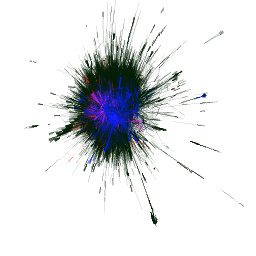

In [14]:
#@title bd487008
@auto.mediocreatbest.with_exit_stack
def scope(env, /, *,   enter):
    gs = GS()

    enter( gs.environment() )
    
    for k, v in env.items():
        gs[k] = v
    
    gs['GS_OUTPUT'] = '<MEMORY>'
    
    enter( gs.egl() )
    enter( gs.gl() )
    enter( gs.data() )
    enter( gs.shader() )
    image = enter( gs.render() )
    
    auto.IPython.display.display(auto.IPython.display.Image(image))

scope({
    "GS_TILE_HEIGHT": "256",
    "GS_TILE_Z": "0",
    "GS_BUFFER_SIZE_0": "2E",
    "GS_BUFFER_SIZE_1": "N",
    "GS_BUFFER_SIZE_2": "N",
    "GS_BUFFER_SIZE_3": "N",
    "GS_SHADER_GEOMETRY": "\nlayout (lines) in;\nlayout (line_strip, max_vertices=2) out;\n\nlayout(location=0) in uint _fg_NodeIndex[];\n\nlayout(location=0) out flat uint gs_SourceIndex;\nlayout(location=1) out flat uint gs_TargetIndex;\n\nvoid main() {\n    gs_SourceIndex = _fg_NodeIndex[0];\n    gs_TargetIndex = _fg_NodeIndex[1];\n\n    int gs_EdgeIndex = gl_PrimitiveIDIn;\n    vec4 gs_SourcePosition = gl_in[0].gl_Position;\n    vec4 gs_TargetPosition = gl_in[1].gl_Position;\n\n\n    #if USE_RELATIONAL\n    uint od = 1 + atomicAdd(out_degree[gs_SourceIndex], 1);\n    atomicCounterMax(out_degree_max, od);\n\n    uint id = 1 + atomicAdd(in_degree[gs_TargetIndex], 1);\n    atomicCounterMax(in_degree_max, id);\n    #endif /* USE_RELATIONAL */\n\n\n\n    // Apply tile transformations\n    gs_SourcePosition.xy *= uScale;\n    gs_SourcePosition.xy += vec2(uTranslateX, uTranslateY);\n\n    // Transform xy in [0, 1] to xy in [-1, 1]\n    gs_SourcePosition.xy *= 2.;\n    gs_SourcePosition.xy -= 1.;\n\n    // Apply tile transformations\n    gs_TargetPosition.xy *= uScale;\n    gs_TargetPosition.xy += vec2(uTranslateX, uTranslateY);\n\n    // Transform xy in [0, 1] to xy in [-1, 1]\n    gs_TargetPosition.xy *= 2.;\n    gs_TargetPosition.xy -= 1.;\n\n    gl_PrimitiveID = gs_EdgeIndex;\n    gl_Position = gs_SourcePosition;\n    EmitVertex();\n\n    gl_Position = gs_TargetPosition;\n    EmitVertex();\n\n    EndPrimitive();\n}\n    ",
    "GS_BUFFER_SIZE_4": "N",
    "GS_BUFFER_SIZE_5": "N",
    "GS_BUFFER_SIZE_6": "N",
    "GS_BUFFER_TYPE_0": "GL_UNSIGNED_INT",
    "GS_BUFFER_SIZE_7": "N",
    "GS_BUFFER_TYPE_1": "GL_FLOAT",
    "GS_BUFFER_SIZE_8": "E",
    "GS_OUTPUT": "out.jpg",
    "GS_BUFFER_BIND_0": "<NONE>",
    "GS_BUFFER_TYPE_2": "GL_FLOAT",
    "GS_BUFFER_SIZE_9": "48",
    "GS_BUFFER_BIND_1": "0",
    "GS_BUFFER_TYPE_3": "GL_UNSIGNED_INT",
    "GS_BUFFER_BIND_2": "1",
    "GS_BUFFER_TYPE_4": "GL_UNSIGNED_INT",
    "GS_BUFFER_FILE_0": "examples/JS-Deps/data/JS-Deps.edge.elements.2u32.bin",
    "GS_BUFFER_BIND_3": "2",
    "GS_BUFFER_TYPE_5": "GL_UNSIGNED_INT",
    "GS_BUFFER_COUNT": "10",
    "GS_BUFFER_NAME_0": "_ELEMENT",
    "GS_BUFFER_FILE_1": "examples/JS-Deps/data/JS-Deps.node.x.f32.bin",
    "GS_BUFFER_BIND_4": "3",
    "GS_BUFFER_TYPE_6": "GL_UNSIGNED_INT",
    "GS_BUFFER_NAME_1": "_X",
    "GS_BUFFER_FILE_2": "examples/JS-Deps/data/JS-Deps.node.y.f32.bin",
    "GS_BUFFER_BIND_5": "4",
    "GS_BUFFER_TYPE_7": "GL_UNSIGNED_INT",
    "GS_BUFFER_NAME_2": "_Y",
    "GS_BUFFER_FILE_3": "examples/JS-Deps/data/JS-Deps.node.date.u32.bin",
    "GS_BUFFER_BIND_6": "5",
    "GS_BUFFER_TYPE_8": "GL_UNSIGNED_INT",
    "GS_ATOMIC_COUNT": "12",
    "GS_BUFFER_NAME_3": "_Date",
    "GS_BUFFER_FILE_4": "examples/JS-Deps/data/JS-Deps.node.nmaintainers.u32.bin",
    "GS_BUFFER_BIND_7": "6",
    "GS_ATOMIC_NAME_0": "in_degree_max",
    "GS_BUFFER_TYPE_9": "GL_UNSIGNED_INT",
    "GS_BUFFER_NAME_4": "_Devs",
    "GS_BUFFER_FILE_5": "examples/JS-Deps/data/JS-Deps.node.cve.u32.bin",
    "GS_ATOMIC_NAME_1": "out_degree_max",
    "GS_BUFFER_BIND_8": "7",
    "GS_SHADER_VERTEX": "\n\nlayout(location=0) out uint _fg_NodeIndex;\n\nvoid main() {\n    const int gs_NodeIndex = gl_VertexID;\n    vec3 gs_NodePosition = vec3(0., 0., 0.);\n\n    float x = X[gs_NodeIndex];\n    float y = Y[gs_NodeIndex];\n\n    gs_NodePosition = vec3(x, y, 0);\n\n\n\n    gl_Position = vec4(gs_NodePosition.xyz, 1.);\n\n    _fg_NodeIndex = gs_NodeIndex;\n}\n    ",
    "GS_BACKGROUND_A": "1.0",
    "GS_BUFFER_KIND_0": "ELEMENT",
    "GS_BUFFER_NAME_5": "_Vuln",
    "GS_BUFFER_FILE_6": "<NONE>",
    "GS_ATOMIC_NAME_2": "total",
    "GS_BUFFER_BIND_9": "0",
    "GS_SHADER_FRAGMENT": "\nlayout(location=0) in flat uint gs_SourceIndex;\nlayout(location=1) in flat uint gs_TargetIndex;\n\nlayout(location=0) out vec4 gs_FragColor;\n\nvoid main() {\n    int gs_EdgeIndex = gl_PrimitiveID;\n    bool first = 0 == atomicAdd(Seen[gs_EdgeIndex], 1);\n    bool d = false;\n\n    if (first) atomicCounterAdd(total, 1);\n\n    #if FILTER_BY_DATE\n\n    if (Date[gs_SourceIndex] < LO) {\n        d = true;\n        if (first) atomicCounterAdd(source_date_too_lo, 1);\n    }\n\n    if (Date[gs_SourceIndex] > HI) {\n        d = true;\n        if (first) atomicCounterAdd(source_date_too_hi, 1);\n    }\n\n    if (Date[gs_TargetIndex] < LO) {\n        d = true;\n        if (first) atomicCounterAdd(target_date_too_lo, 1);\n    }\n\n    if (Date[gs_TargetIndex] > HI) {\n        d = true;\n        if (first) atomicCounterAdd(target_date_too_hi, 1);\n    }\n    #endif /* FILTER_BY_DATE */\n\n    if (d) {\n        if (first) atomicCounterAdd(discarded, 1);\n        discard;\n    } else {\n        if (first) atomicCounterAdd(kept, 1);\n    }\n\n    bool vuln = bool(Vuln[gs_SourceIndex]) || bool(Vuln[gs_TargetIndex]);\n    bool risky = Devs[gs_SourceIndex] > Devs[gs_TargetIndex];\n\n    #if USE_RELATIONAL\n    const uint depends_on_source = in_degree[gs_SourceIndex];\n    const uint depends_on_target = in_degree[gs_TargetIndex];\n\n    risky = depends_on_source + depends_on_target > 100 * Devs[gs_TargetIndex];\n    #endif /* USE_RELATIONAL */\n\n    if (risky) {\n        if (first) atomicCounterAdd(total_risky, 1);\n    }\n\n    if (risky && vuln) {\n        if (first) atomicCounterAdd(total_vuln_and_risky, 1);\n    }\n\n    if (vuln) {\n        if (first) atomicCounterAdd(total_vuln, 1);\n    }\n\n    gs_FragColor = vec4(0.1);\n    gs_FragColor.r = float(vuln);\n    gs_FragColor.b = float(risky);\n}\n    ",
    "GS_BACKGROUND_B": "1.0",
    "GS_BUFFER_KIND_1": "ATTRIBUTE",
    "GS_BUFFER_NAME_6": "_in_degree",
    "GS_BUFFER_FILE_7": "<NONE>",
    "GS_ATOMIC_NAME_3": "source_date_too_lo",
    "GS_TILE_WIDTH": "256",
    "GS_BUFFER_KIND_2": "ATTRIBUTE",
    "GS_BUFFER_NAME_7": "_out_degree",
    "GS_BUFFER_FILE_8": "<NONE>",
    "GS_ATOMIC_NAME_4": "source_date_too_hi",
    "GS_BUFFER_KIND_3": "ATTRIBUTE",
    "GS_BUFFER_NAME_8": "_Seen",
    "GS_ATOMIC_NAME_5": "target_date_too_lo",
    "GS_BUFFER_FILE_9": "<NONE>",
    "GS_BUFFER_KIND_4": "ATTRIBUTE",
    "GS_ATOMIC_NAME_6": "target_date_too_hi",
    "GS_BUFFER_NAME_9": "_ATOMIC",
    "GS_BUFFER_KIND_5": "ATTRIBUTE",
    "GS_ATOMIC_NAME_7": "discarded",
    "GS_BACKGROUND_G": "1.0",
    "GS_BUFFER_KIND_6": "SCRATCH",
    "GS_ATOMIC_NAME_8": "kept",
    "GS_BUFFER_KIND_7": "SCRATCH",
    "GS_ATOMIC_NAME_9": "total_risky",
    "GS_BUFFER_KIND_8": "SCRATCH",
    "GS_ATOMIC_NAME_10": "total_vuln_and_risky",
    "GS_ATOMIC_NAME_11": "total_vuln",
    "GS_BUFFER_KIND_9": "ATOMIC",
    "GS_BACKGROUND_R": "1.0",
    "GS_SHADER_COMMON": "\n#version 460 core\nprecision mediump float;\n\nuniform float uTranslateX;\nuniform float uTranslateY;\nuniform float uScale;\n// JS-Deps: Node Package Manager Dependency Graph\n//\n// Nodes are packages. Edges are directed from a package to its dependencies.\n\nlayout (std430, binding=0) buffer _X { float X[]; }; // attribute(float X[N])\nlayout (std430, binding=1) buffer _Y { float Y[]; }; // attribute(float Y[N])\nlayout (std430, binding=2) buffer _Date { uint Date[]; }; // attribute(uint Date[N])\nlayout (std430, binding=3) buffer _Devs { uint Devs[]; }; // attribute(uint Devs[N])\nlayout (std430, binding=4) buffer _Vuln { uint Vuln[]; }; // attribute(uint Vuln[N])\n\n#define NOV_09_2010 1289278800\n#define MAR_22_2016 1458619200\n\n#define JAN_01_2011 1293858000\n#define JAN_01_2012 1325394000\n#define JAN_01_2013 1357016400\n#define JAN_01_2014 1388552400\n#define JAN_01_2015 1420088400\n#define JAN_01_2016 1451624400\n\n// Some controls\n\n\nlayout (std430, binding=5) buffer _in_degree { uint in_degree[]; }; // scratch(uint in_degree[N])\nlayout (std430, binding=6) buffer _out_degree { uint out_degree[]; }; // scratch(uint out_degree[N])\nlayout (binding=0, offset=0) uniform atomic_uint in_degree_max; // scratch(atomic_uint in_degree_max)\nlayout (binding=0, offset=4) uniform atomic_uint out_degree_max; // scratch(atomic_uint out_degree_max)\n#define USE_RELATIONAL 1\nlayout (std430, binding=7) buffer _Seen { uint Seen[]; }; // scratch(uint Seen[E])\nlayout (binding=0, offset=8) uniform atomic_uint total; // scratch(atomic_uint total)\n#define FILTER_BY_DATE 1\n#define LO JAN_01_2014\n#define HI JAN_01_2015\nlayout (binding=0, offset=12) uniform atomic_uint source_date_too_lo; // scratch(atomic_uint source_date_too_lo)\nlayout (binding=0, offset=16) uniform atomic_uint source_date_too_hi; // scratch(atomic_uint source_date_too_hi)\nlayout (binding=0, offset=20) uniform atomic_uint target_date_too_lo; // scratch(atomic_uint target_date_too_lo)\nlayout (binding=0, offset=24) uniform atomic_uint target_date_too_hi; // scratch(atomic_uint target_date_too_hi)\nlayout (binding=0, offset=28) uniform atomic_uint discarded; // scratch(atomic_uint discarded)\nlayout (binding=0, offset=32) uniform atomic_uint kept; // scratch(atomic_uint kept)\nlayout (binding=0, offset=36) uniform atomic_uint total_risky; // scratch(atomic_uint total_risky)\nlayout (binding=0, offset=40) uniform atomic_uint total_vuln_and_risky; // scratch(atomic_uint total_vuln_and_risky)\nlayout (binding=0, offset=44) uniform atomic_uint total_vuln; // scratch(atomic_uint total_vuln)\n    ",
    "GS_TILE_X": "0",
    "GS_TILE_Y": "0"
})


In [17]:
#@title 6cc786d9
def scope():
    env = Transpile(
        auto.pathlib.Path('examples/JS-Deps/JS-Deps.gsp').read_text(),
        files=dict(
        ),
    )

    with auto.mediocreatbest.Textarea():
        print(auto.json.dumps({
            k: v
            for k, v in env.items()
            if k.startswith('GS_')
        }, indent=4))

/scope


os.execlpe('/tmp/tmpoxjw6b69/printenv0', '/tmp/tmpoxjw6b69/printenv0 <inpfile>', env)


EGL_VERSION: 1.5
EGL_VENDOR: NVIDIA
EGL_CLIENT_APIS: OpenGL_ES OpenGL
EGL_EXTENSIONS: EGL_EXT_buffer_age EGL_EXT_client_sync EGL_EXT_create_context_robustness EGL_EXT_image_dma_buf_import EGL_EXT_image_dma_buf_import_modifiers EGL_MESA_image_dma_buf_export EGL_EXT_output_base EGL_EXT_protected_content EGL_EXT_stream_acquire_mode EGL_EXT_sync_reuse EGL_IMG_context_priority EGL_KHR_config_attribs EGL_KHR_create_context_no_error EGL_KHR_context_flush_control EGL_KHR_create_context EGL_KHR_fence_sync EGL_KHR_get_all_proc_addresses EGL_KHR_partial_update EGL_KHR_swap_buffers_with_damage EGL_KHR_no_config_context EGL_KHR_gl_colorspace EGL_KHR_gl_renderbuffer_image EGL_KHR_gl_texture_2D_image EGL_KHR_gl_texture_3D_image EGL_KHR_gl_texture_cubemap_image EGL_KHR_image EGL_KHR_image_base EGL_KHR_reusable_sync EGL_KHR_stream EGL_KHR_stream_attrib EGL_KHR_stream_consumer_gltexture EGL_KHR_stream_cross_process_fd EGL_KHR_stream_fifo EGL_KHR_stream_producer_eglsurface EGL_KHR_surfaceless_context EGL

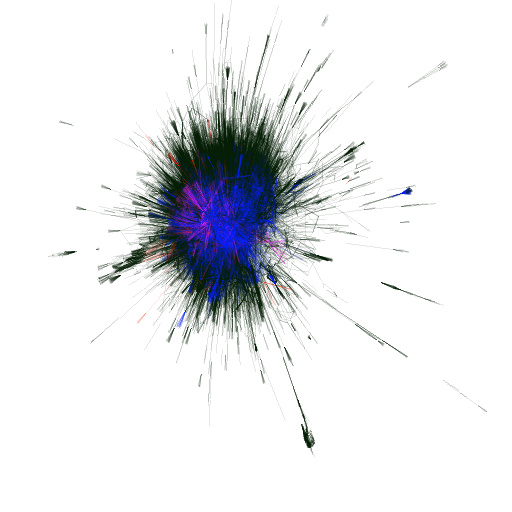

In [19]:
#@title 8da4103f
@auto.mediocreatbest.with_exit_stack
def scope(env, /, *,   enter):
    gs = GS()

    def Read(path: auto.os.PathLike, /, *, dtype: auto.np.DType) -> auto.np.ndarray:
        return auto.np.fromfile(path, dtype)

    element = Read("examples/JS-Deps/data/JS-Deps.edge.elements.2u32.bin",
        dtype=[ ('i', 'u4'), ('j', 'u4') ],
    )
    x = Read("examples/JS-Deps/data/JS-Deps.node.x.f32.bin",
        dtype=[ ('x', 'f4') ],
    )
    y = Read("examples/JS-Deps/data/JS-Deps.node.y.f32.bin",
        dtype=[ ('y', 'f4') ],
    )
    date = Read("examples/JS-Deps/data/JS-Deps.node.date.u32.bin",
        dtype=[ ('date', 'u4') ],
    )
    devs = Read("examples/JS-Deps/data/JS-Deps.node.nmaintainers.u32.bin",
        dtype=[ ('devs', 'u4') ],
    )
    vuln = Read("examples/JS-Deps/data/JS-Deps.node.cve.u32.bin",
        dtype=[ ('vuln', 'u4') ],
    )

    enter( gs.environment() )
    
    for k, v in env.items():
        gs[k] = v
    
    enter( gs.egl() )
    
    gs['GS_TILE_WIDTH'] = '512'
    gs['GS_TILE_HEIGHT'] = '512'
    enter( gs.gl() )
    
    gs['_ELEMENT'] = element
    gs['_X'] = x
    gs['_Y'] = y
    gs['_Date'] = date
    gs['_Devs'] = devs
    gs['_Vuln'] = vuln
    enter( gs.data() )

    enter( gs.shader() )
    
    gs['GS_OUTPUT'] = '<MEMORY>'
    image = enter( gs.render() )
    auto.IPython.display.display(auto.IPython.display.Image(image))

scope({
    "GS_TILE_HEIGHT": "256",
    "GS_TILE_Z": "0",
    "GS_BUFFER_SIZE_0": "2E",
    "GS_BUFFER_SIZE_1": "N",
    "GS_BUFFER_SIZE_2": "N",
    "GS_BUFFER_SIZE_3": "N",
    "GS_SHADER_GEOMETRY": "\nlayout (lines) in;\nlayout (line_strip, max_vertices=2) out;\n\nlayout(location=0) in uint _fg_NodeIndex[];\n\nlayout(location=0) out flat uint gs_SourceIndex;\nlayout(location=1) out flat uint gs_TargetIndex;\n\nvoid main() {\n    gs_SourceIndex = _fg_NodeIndex[0];\n    gs_TargetIndex = _fg_NodeIndex[1];\n\n    int gs_EdgeIndex = gl_PrimitiveIDIn;\n    vec4 gs_SourcePosition = gl_in[0].gl_Position;\n    vec4 gs_TargetPosition = gl_in[1].gl_Position;\n\n\n    #if USE_RELATIONAL\n    uint od = 1 + atomicAdd(out_degree[gs_SourceIndex], 1);\n    atomicCounterMax(out_degree_max, od);\n\n    uint id = 1 + atomicAdd(in_degree[gs_TargetIndex], 1);\n    atomicCounterMax(in_degree_max, id);\n    #endif /* USE_RELATIONAL */\n\n\n\n    // Apply tile transformations\n    gs_SourcePosition.xy *= uScale;\n    gs_SourcePosition.xy += vec2(uTranslateX, uTranslateY);\n\n    // Transform xy in [0, 1] to xy in [-1, 1]\n    gs_SourcePosition.xy *= 2.;\n    gs_SourcePosition.xy -= 1.;\n\n    // Apply tile transformations\n    gs_TargetPosition.xy *= uScale;\n    gs_TargetPosition.xy += vec2(uTranslateX, uTranslateY);\n\n    // Transform xy in [0, 1] to xy in [-1, 1]\n    gs_TargetPosition.xy *= 2.;\n    gs_TargetPosition.xy -= 1.;\n\n    gl_PrimitiveID = gs_EdgeIndex;\n    gl_Position = gs_SourcePosition;\n    EmitVertex();\n\n    gl_Position = gs_TargetPosition;\n    EmitVertex();\n\n    EndPrimitive();\n}\n    ",
    "GS_BUFFER_SIZE_4": "N",
    "GS_BUFFER_SIZE_5": "N",
    "GS_BUFFER_SIZE_6": "N",
    "GS_BUFFER_TYPE_0": "GL_UNSIGNED_INT",
    "GS_BUFFER_SIZE_7": "N",
    "GS_BUFFER_TYPE_1": "GL_FLOAT",
    "GS_BUFFER_SIZE_8": "E",
    "GS_OUTPUT": "out.jpg",
    "GS_BUFFER_BIND_0": "<NONE>",
    "GS_BUFFER_TYPE_2": "GL_FLOAT",
    "GS_BUFFER_SIZE_9": "48",
    "GS_BUFFER_BIND_1": "0",
    "GS_BUFFER_TYPE_3": "GL_UNSIGNED_INT",
    "GS_BUFFER_BIND_2": "1",
    "GS_BUFFER_TYPE_4": "GL_UNSIGNED_INT",
    "GS_BUFFER_FILE_0": "<NONE>",
    "GS_BUFFER_BIND_3": "2",
    "GS_BUFFER_TYPE_5": "GL_UNSIGNED_INT",
    "GS_BUFFER_COUNT": "10",
    "GS_BUFFER_NAME_0": "_ELEMENT",
    "GS_BUFFER_FILE_1": "<NONE>",
    "GS_BUFFER_BIND_4": "3",
    "GS_BUFFER_TYPE_6": "GL_UNSIGNED_INT",
    "GS_BUFFER_NAME_1": "_X",
    "GS_BUFFER_FILE_2": "<NONE>",
    "GS_BUFFER_BIND_5": "4",
    "GS_BUFFER_TYPE_7": "GL_UNSIGNED_INT",
    "GS_BUFFER_NAME_2": "_Y",
    "GS_BUFFER_FILE_3": "<NONE>",
    "GS_BUFFER_BIND_6": "5",
    "GS_BUFFER_TYPE_8": "GL_UNSIGNED_INT",
    "GS_ATOMIC_COUNT": "12",
    "GS_BUFFER_NAME_3": "_Date",
    "GS_BUFFER_FILE_4": "<NONE>",
    "GS_BUFFER_BIND_7": "6",
    "GS_ATOMIC_NAME_0": "in_degree_max",
    "GS_BUFFER_TYPE_9": "GL_UNSIGNED_INT",
    "GS_BUFFER_NAME_4": "_Devs",
    "GS_BUFFER_FILE_5": "<NONE>",
    "GS_ATOMIC_NAME_1": "out_degree_max",
    "GS_BUFFER_BIND_8": "7",
    "GS_SHADER_VERTEX": "\n\nlayout(location=0) out uint _fg_NodeIndex;\n\nvoid main() {\n    const int gs_NodeIndex = gl_VertexID;\n    vec3 gs_NodePosition = vec3(0., 0., 0.);\n\n    float x = X[gs_NodeIndex];\n    float y = Y[gs_NodeIndex];\n\n    gs_NodePosition = vec3(x, y, 0);\n\n\n\n    gl_Position = vec4(gs_NodePosition.xyz, 1.);\n\n    _fg_NodeIndex = gs_NodeIndex;\n}\n    ",
    "GS_BACKGROUND_A": "1.0",
    "GS_BUFFER_KIND_0": "ELEMENT",
    "GS_BUFFER_NAME_5": "_Vuln",
    "GS_BUFFER_FILE_6": "<NONE>",
    "GS_ATOMIC_NAME_2": "total",
    "GS_BUFFER_BIND_9": "0",
    "GS_SHADER_FRAGMENT": "\nlayout(location=0) in flat uint gs_SourceIndex;\nlayout(location=1) in flat uint gs_TargetIndex;\n\nlayout(location=0) out vec4 gs_FragColor;\n\nvoid main() {\n    int gs_EdgeIndex = gl_PrimitiveID;\n    bool first = 0 == atomicAdd(Seen[gs_EdgeIndex], 1);\n    bool d = false;\n\n    if (first) atomicCounterAdd(total, 1);\n\n    #if FILTER_BY_DATE\n\n    if (Date[gs_SourceIndex] < LO) {\n        d = true;\n        if (first) atomicCounterAdd(source_date_too_lo, 1);\n    }\n\n    if (Date[gs_SourceIndex] > HI) {\n        d = true;\n        if (first) atomicCounterAdd(source_date_too_hi, 1);\n    }\n\n    if (Date[gs_TargetIndex] < LO) {\n        d = true;\n        if (first) atomicCounterAdd(target_date_too_lo, 1);\n    }\n\n    if (Date[gs_TargetIndex] > HI) {\n        d = true;\n        if (first) atomicCounterAdd(target_date_too_hi, 1);\n    }\n    #endif /* FILTER_BY_DATE */\n\n    if (d) {\n        if (first) atomicCounterAdd(discarded, 1);\n        discard;\n    } else {\n        if (first) atomicCounterAdd(kept, 1);\n    }\n\n    bool vuln = bool(Vuln[gs_SourceIndex]) || bool(Vuln[gs_TargetIndex]);\n    bool risky = Devs[gs_SourceIndex] > Devs[gs_TargetIndex];\n\n    #if USE_RELATIONAL\n    const uint depends_on_source = in_degree[gs_SourceIndex];\n    const uint depends_on_target = in_degree[gs_TargetIndex];\n\n    risky = depends_on_source + depends_on_target > 100 * Devs[gs_TargetIndex];\n    #endif /* USE_RELATIONAL */\n\n    if (risky) {\n        if (first) atomicCounterAdd(total_risky, 1);\n    }\n\n    if (risky && vuln) {\n        if (first) atomicCounterAdd(total_vuln_and_risky, 1);\n    }\n\n    if (vuln) {\n        if (first) atomicCounterAdd(total_vuln, 1);\n    }\n\n    gs_FragColor = vec4(0.1);\n    gs_FragColor.r = float(vuln);\n    gs_FragColor.b = float(risky);\n}\n    ",
    "GS_BACKGROUND_B": "1.0",
    "GS_BUFFER_KIND_1": "ATTRIBUTE",
    "GS_BUFFER_NAME_6": "_in_degree",
    "GS_BUFFER_FILE_7": "<NONE>",
    "GS_ATOMIC_NAME_3": "source_date_too_lo",
    "GS_TILE_WIDTH": "256",
    "GS_BUFFER_KIND_2": "ATTRIBUTE",
    "GS_BUFFER_NAME_7": "_out_degree",
    "GS_BUFFER_FILE_8": "<NONE>",
    "GS_ATOMIC_NAME_4": "source_date_too_hi",
    "GS_BUFFER_KIND_3": "ATTRIBUTE",
    "GS_BUFFER_NAME_8": "_Seen",
    "GS_ATOMIC_NAME_5": "target_date_too_lo",
    "GS_BUFFER_FILE_9": "<NONE>",
    "GS_BUFFER_KIND_4": "ATTRIBUTE",
    "GS_ATOMIC_NAME_6": "target_date_too_hi",
    "GS_BUFFER_NAME_9": "_ATOMIC",
    "GS_BUFFER_KIND_5": "ATTRIBUTE",
    "GS_ATOMIC_NAME_7": "discarded",
    "GS_BACKGROUND_G": "1.0",
    "GS_BUFFER_KIND_6": "SCRATCH",
    "GS_ATOMIC_NAME_8": "kept",
    "GS_BUFFER_KIND_7": "SCRATCH",
    "GS_ATOMIC_NAME_9": "total_risky",
    "GS_BUFFER_KIND_8": "SCRATCH",
    "GS_ATOMIC_NAME_10": "total_vuln_and_risky",
    "GS_ATOMIC_NAME_11": "total_vuln",
    "GS_BUFFER_KIND_9": "ATOMIC",
    "GS_BACKGROUND_R": "1.0",
    "GS_SHADER_COMMON": "\n#version 460 core\nprecision mediump float;\n\nuniform float uTranslateX;\nuniform float uTranslateY;\nuniform float uScale;\n// JS-Deps: Node Package Manager Dependency Graph\n//\n// Nodes are packages. Edges are directed from a package to its dependencies.\n\nlayout (std430, binding=0) buffer _X { float X[]; }; // attribute(float X[N])\nlayout (std430, binding=1) buffer _Y { float Y[]; }; // attribute(float Y[N])\nlayout (std430, binding=2) buffer _Date { uint Date[]; }; // attribute(uint Date[N])\nlayout (std430, binding=3) buffer _Devs { uint Devs[]; }; // attribute(uint Devs[N])\nlayout (std430, binding=4) buffer _Vuln { uint Vuln[]; }; // attribute(uint Vuln[N])\n\n#define NOV_09_2010 1289278800\n#define MAR_22_2016 1458619200\n\n#define JAN_01_2011 1293858000\n#define JAN_01_2012 1325394000\n#define JAN_01_2013 1357016400\n#define JAN_01_2014 1388552400\n#define JAN_01_2015 1420088400\n#define JAN_01_2016 1451624400\n\n// Some controls\n\n\nlayout (std430, binding=5) buffer _in_degree { uint in_degree[]; }; // scratch(uint in_degree[N])\nlayout (std430, binding=6) buffer _out_degree { uint out_degree[]; }; // scratch(uint out_degree[N])\nlayout (binding=0, offset=0) uniform atomic_uint in_degree_max; // scratch(atomic_uint in_degree_max)\nlayout (binding=0, offset=4) uniform atomic_uint out_degree_max; // scratch(atomic_uint out_degree_max)\n#define USE_RELATIONAL 1\nlayout (std430, binding=7) buffer _Seen { uint Seen[]; }; // scratch(uint Seen[E])\nlayout (binding=0, offset=8) uniform atomic_uint total; // scratch(atomic_uint total)\n#define FILTER_BY_DATE 1\n#define LO JAN_01_2014\n#define HI JAN_01_2015\nlayout (binding=0, offset=12) uniform atomic_uint source_date_too_lo; // scratch(atomic_uint source_date_too_lo)\nlayout (binding=0, offset=16) uniform atomic_uint source_date_too_hi; // scratch(atomic_uint source_date_too_hi)\nlayout (binding=0, offset=20) uniform atomic_uint target_date_too_lo; // scratch(atomic_uint target_date_too_lo)\nlayout (binding=0, offset=24) uniform atomic_uint target_date_too_hi; // scratch(atomic_uint target_date_too_hi)\nlayout (binding=0, offset=28) uniform atomic_uint discarded; // scratch(atomic_uint discarded)\nlayout (binding=0, offset=32) uniform atomic_uint kept; // scratch(atomic_uint kept)\nlayout (binding=0, offset=36) uniform atomic_uint total_risky; // scratch(atomic_uint total_risky)\nlayout (binding=0, offset=40) uniform atomic_uint total_vuln_and_risky; // scratch(atomic_uint total_vuln_and_risky)\nlayout (binding=0, offset=44) uniform atomic_uint total_vuln; // scratch(atomic_uint total_vuln)\n    ",
    "GS_TILE_X": "0",
    "GS_TILE_Y": "0"
})


# 3rd

In [56]:
JSDeps = Graph(
    files=dict(
        element="examples/JS-Deps/data/JS-Deps.edge.elements.2u32.bin",
        X      ="examples/JS-Deps/data/JS-Deps.node.x.f32.bin",
        Y      ="examples/JS-Deps/data/JS-Deps.node.y.f32.bin",
        Date   ="examples/JS-Deps/data/JS-Deps.node.date.u32.bin",
        Devs   ="examples/JS-Deps/data/JS-Deps.node.nmaintainers.u32.bin",
        Vuln   ="examples/JS-Deps/data/JS-Deps.node.cve.u32.bin",
    ),
    size=(512, 512),
    tile=(0, 0, 0),
    verbose=True,
)


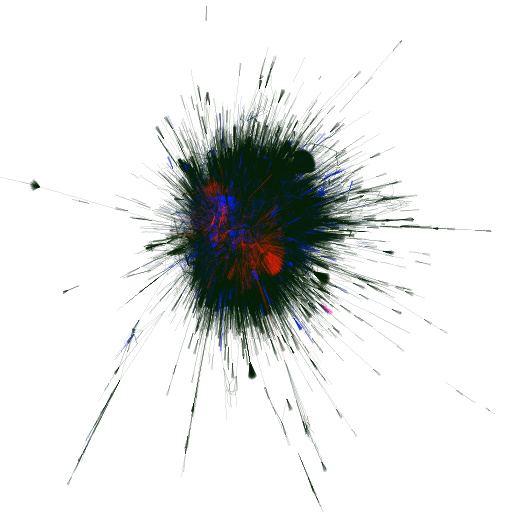

In [58]:
%%.render -n JSDeps
#pragma gs attribute(float X[N])
#pragma gs attribute(float Y[N])
#pragma gs attribute(uint Date[N])
#pragma gs attribute(uint Devs[N])
#pragma gs attribute(uint Vuln[N])

#define NOV_09_2010 1289278800
#define MAR_22_2016 1458619200

#define JAN_01_2011 1293858000
#define JAN_01_2012 1325394000
#define JAN_01_2013 1357016400
#define JAN_01_2014 1388552400
#define JAN_01_2015 1420088400
#define JAN_01_2016 1451624400

#pragma gs shader(positional)
void main() {
    float x = X[gs_NodeIndex];
    float y = Y[gs_NodeIndex];

    gs_NodePosition = vec3(x, y, 0);
}

#pragma gs shader(relational)
void main() {
}

#pragma gs shader(appearance)
void main() {
    bool d = false;

    #pragma gs define(LO JAN_01_2015)
    #pragma gs define(HI JAN_01_2016)
    d = d || Date[gs_SourceIndex] < LO;
    d = d || Date[gs_SourceIndex] > HI;
    d = d || Date[gs_TargetIndex] < LO;
    d = d || Date[gs_TargetIndex] > HI;
    
    if (d) discard;
    
    bool vuln = bool(Vuln[gs_SourceIndex]) || bool(Vuln[gs_TargetIndex]);
    bool risky = Devs[gs_SourceIndex] > Devs[gs_TargetIndex];

    gs_FragColor = vec4(0.1);
    gs_FragColor.r = float(vuln);
    gs_FragColor.b = float(risky);
}


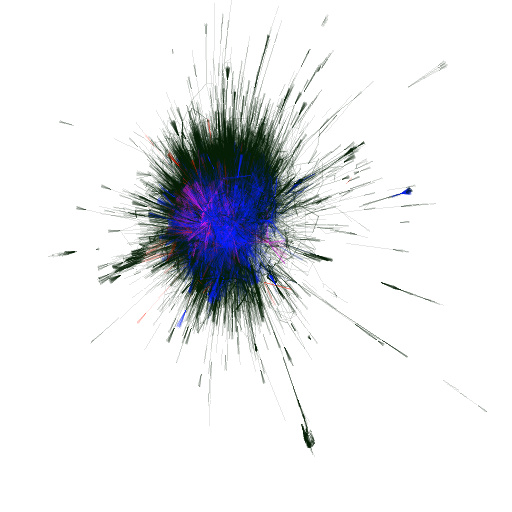

In [59]:
%%.render -n JSDeps
// JS-Deps: Node Package Manager Dependency Graph
//
// Nodes are packages. Edges are directed from a package to its dependencies.

#pragma gs attribute(float X[N])
#pragma gs attribute(float Y[N])
#pragma gs attribute(uint Date[N])
#pragma gs attribute(uint Devs[N])
#pragma gs attribute(uint Vuln[N])

#define NOV_09_2010 1289278800
#define MAR_22_2016 1458619200

#define JAN_01_2011 1293858000
#define JAN_01_2012 1325394000
#define JAN_01_2013 1357016400
#define JAN_01_2014 1388552400
#define JAN_01_2015 1420088400
#define JAN_01_2016 1451624400

// Some controls
#pragma gs define(USE_COLOR)
#pragma gs define(USE_FILTER)
#pragma gs define(USE_RELATIONAL)


#pragma gs shader(positional)
void main() {
    float x = X[gs_NodeIndex];
    float y = Y[gs_NodeIndex];

    gs_NodePosition = vec3(x, y, 0);
}


#pragma gs shader(relational)
void main() {
    #pragma gs scratch(uint in_degree[N])
    #pragma gs scratch(uint out_degree[N])
    #pragma gs scratch(atomic_uint in_degree_max)
    #pragma gs scratch(atomic_uint out_degree_max)

    #pragma gs define(USE_RELATIONAL 1)
    #if USE_RELATIONAL
    uint od = 1 + atomicAdd(out_degree[gs_SourceIndex], 1);
    atomicCounterMax(out_degree_max, od);

    uint id = 1 + atomicAdd(in_degree[gs_TargetIndex], 1);
    atomicCounterMax(in_degree_max, id);
    #endif /* USE_RELATIONAL */
}


#pragma gs shader(appearance)
void main() {
    #pragma gs scratch(uint Seen[E])
    bool first = 0 == atomicAdd(Seen[gs_EdgeIndex], 1);
    bool d = false;

    #pragma gs scratch(atomic_uint total)
    if (first) atomicCounterAdd(total, 1);

    #pragma gs define(FILTER_BY_DATE 1)
    #if FILTER_BY_DATE
    #pragma gs define(LO JAN_01_2014)
    #pragma gs define(HI JAN_01_2015)

    if (Date[gs_SourceIndex] < LO) {
        d = true;
        #pragma gs scratch(atomic_uint source_date_too_lo)
        if (first) atomicCounterAdd(source_date_too_lo, 1);
    }

    if (Date[gs_SourceIndex] > HI) {
        d = true;
        #pragma gs scratch(atomic_uint source_date_too_hi)
        if (first) atomicCounterAdd(source_date_too_hi, 1);
    }

    if (Date[gs_TargetIndex] < LO) {
        d = true;
        #pragma gs scratch(atomic_uint target_date_too_lo)
        if (first) atomicCounterAdd(target_date_too_lo, 1);
    }

    if (Date[gs_TargetIndex] > HI) {
        d = true;
        #pragma gs scratch(atomic_uint target_date_too_hi)
        if (first) atomicCounterAdd(target_date_too_hi, 1);
    }
    #endif /* FILTER_BY_DATE */

    if (d) {
        #pragma gs scratch(atomic_uint discarded)
        if (first) atomicCounterAdd(discarded, 1);
        discard;
    } else {
        #pragma gs scratch(atomic_uint kept)
        if (first) atomicCounterAdd(kept, 1);
    }

    bool vuln = bool(Vuln[gs_SourceIndex]) || bool(Vuln[gs_TargetIndex]);
    bool risky = Devs[gs_SourceIndex] > Devs[gs_TargetIndex];

    #if USE_RELATIONAL
    const uint depends_on_source = in_degree[gs_SourceIndex];
    const uint depends_on_target = in_degree[gs_TargetIndex];

    risky = depends_on_source + depends_on_target > 100 * Devs[gs_TargetIndex];
    #endif /* USE_RELATIONAL */

    if (risky) {
        #pragma gs scratch(atomic_uint total_risky)
        if (first) atomicCounterAdd(total_risky, 1);
    }

    if (risky && vuln) {
        #pragma gs scratch(atomic_uint total_vuln_and_risky)
        if (first) atomicCounterAdd(total_vuln_and_risky, 1);
    }

    if (vuln) {
        #pragma gs scratch(atomic_uint total_vuln)
        if (first) atomicCounterAdd(total_vuln, 1);
    }

    gs_FragColor = vec4(0.1);
    gs_FragColor.r = float(vuln);
    gs_FragColor.b = float(risky);
}


In [60]:
SOAnswers = Graph(
    files=dict(
        element="examples/SO-Answers/data/SO-Answers.edge.element.2u32.bin",
        X="examples/SO-Answers/data/SO-Answers.node.x.f32.bin",
        Y="examples/SO-Answers/data/SO-Answers.node.y.f32.bin",
        When="examples/SO-Answers/data/SO-Answers.edge.when.u32.bin",
    ),
    size=(512, 512),
    tile=(0, 0, 0),
)


EGL_VERSION: 1.5
EGL_VENDOR: NVIDIA
EGL_CLIENT_APIS: OpenGL_ES OpenGL
EGL_EXTENSIONS: EGL_EXT_buffer_age EGL_EXT_client_sync EGL_EXT_create_context_robustness EGL_EXT_image_dma_buf_import EGL_EXT_image_dma_buf_import_modifiers EGL_MESA_image_dma_buf_export EGL_EXT_output_base EGL_EXT_protected_content EGL_EXT_stream_acquire_mode EGL_EXT_sync_reuse EGL_IMG_context_priority EGL_KHR_config_attribs EGL_KHR_create_context_no_error EGL_KHR_context_flush_control EGL_KHR_create_context EGL_KHR_fence_sync EGL_KHR_get_all_proc_addresses EGL_KHR_partial_update EGL_KHR_swap_buffers_with_damage EGL_KHR_no_config_context EGL_KHR_gl_colorspace EGL_KHR_gl_renderbuffer_image EGL_KHR_gl_texture_2D_image EGL_KHR_gl_texture_3D_image EGL_KHR_gl_texture_cubemap_image EGL_KHR_image EGL_KHR_image_base EGL_KHR_reusable_sync EGL_KHR_stream EGL_KHR_stream_attrib EGL_KHR_stream_consumer_gltexture EGL_KHR_stream_cross_process_fd EGL_KHR_stream_fifo EGL_KHR_stream_producer_eglsurface EGL_KHR_surfaceless_context EGL

{
  "metadata": {
     "nodes": 1233244,
     "edges": 12149913
  },
  "atomics": {
    "MaxCommentsReceived": 5129,
    "MaxCommentsPosted": 28799
  }
}


Wrote 279009 bytes to /tmp/tmpljs4yz2y/outfile.jpg


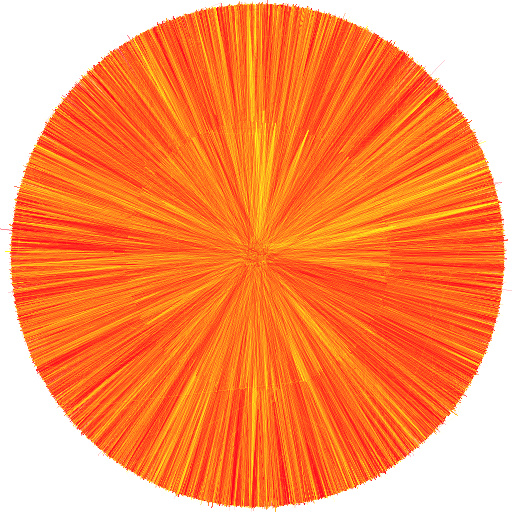

In [63]:
%%.render -n SOAnswers -v
#pragma gs attribute(float X[N])
#pragma gs attribute(float Y[N])
#pragma gs attribute(uint When[E])

#define AUG_01_2008 1217563200
#define MAR_07_2016 1457326800

#define JAN_01_2011 1293858000
#define JAN_01_2012 1325394000
#define JAN_01_2013 1357016400
#define JAN_01_2014 1388552400
#define JAN_01_2015 1420088400
#define JAN_01_2016 1451624400

#pragma gs define(LAYOUT 1)

#pragma gs shader(positional)
void main() {
    float x = X[gs_NodeIndex];
    float y = Y[gs_NodeIndex];

    gs_NodePosition = vec3(x, y, 0.);
}


#pragma gs shader(relational)
void main() {
    const uint when = When[gs_EdgeIndex];

    #pragma gs scratch(uint FirstContribution[N])

    atomicCompSwap(FirstContribution[gs_SourceIndex], 0, when);
    atomicMin(FirstContribution[gs_SourceIndex], when);

    atomicCompSwap(FirstContribution[gs_TargetIndex], 0, when);
    atomicMin(FirstContribution[gs_TargetIndex], when);

    #pragma gs scratch(uint LastContribution[N])

    atomicCompSwap(LastContribution[gs_SourceIndex], 0, when);
    atomicMax(LastContribution[gs_SourceIndex], when);

    atomicCompSwap(LastContribution[gs_TargetIndex], 0, when);
    atomicMax(LastContribution[gs_TargetIndex], when);

    #pragma gs scratch(uint CommentsReceived[N])
    #pragma gs scratch(atomic_uint MaxCommentsReceived)
    uint cr = 1 + atomicAdd(CommentsReceived[gs_TargetIndex], 1);
    atomicCounterMax(MaxCommentsReceived, cr);

    #pragma gs scratch(uint CommentsPosted[N])
    #pragma gs scratch(atomic_uint MaxCommentsPosted)
    uint cp = 1 + atomicAdd(CommentsPosted[gs_SourceIndex], 1);
    atomicCounterMax(MaxCommentsPosted, cp);

    if (LAYOUT == 2) {
        gs_SourcePosition.x = float(FirstContribution[gs_SourceIndex] - AUG_01_2008) / float(MAR_07_2016 - AUG_01_2008);
        gs_SourcePosition.y = 1. - float(LastContribution[gs_SourceIndex] - AUG_01_2008) / float(MAR_07_2016 - AUG_01_2008);

        gs_TargetPosition.x = float(FirstContribution[gs_TargetIndex] - AUG_01_2008) / float(MAR_07_2016 - AUG_01_2008);
        gs_TargetPosition.y = 1. - float(LastContribution[gs_TargetIndex] - AUG_01_2008) / float(MAR_07_2016 - AUG_01_2008);
    }
}

#pragma gs shader(appearance)
void main() {
    bool b1 = CommentsPosted[gs_SourceIndex] >= CommentsReceived[gs_SourceIndex] / 32;
    
    const uint sourceSpan = LastContribution[gs_SourceIndex] - FirstContribution[gs_SourceIndex];
    const uint targetSpan = LastContribution[gs_TargetIndex] - FirstContribution[gs_TargetIndex];
    bool b2 = targetSpan >= sourceSpan;

    gs_FragColor = vec4(0.1);
    gs_FragColor.r = float(b1 || b2);
    gs_FragColor.g = float(b1 && b2);
}


In [64]:
NBERPatents = Graph(
    files=dict(
        element="examples/NBER-Patents/data/NBER-Patents.edge.element.2u32.bin",
        X=      "examples/NBER-Patents/data/NBER-Patents.node.x.f32.bin", 
        Y=      "examples/NBER-Patents/data/NBER-Patents.node.y.f32.bin", 
        GotYear="examples/NBER-Patents/data/NBER-Patents.node.gotyear.u32.bin",
        AppYear="examples/NBER-Patents/data/NBER-Patents.node.appyear.u32.bin",
        Cat1=   "examples/NBER-Patents/data/NBER-Patents.node.cat1.u32.bin", 
        Cat2=   "examples/NBER-Patents/data/NBER-Patents.node.cat2.u32.bin",
    ),
    size=(512, 512),
    tile=(1, 0.25, 0.5),
)


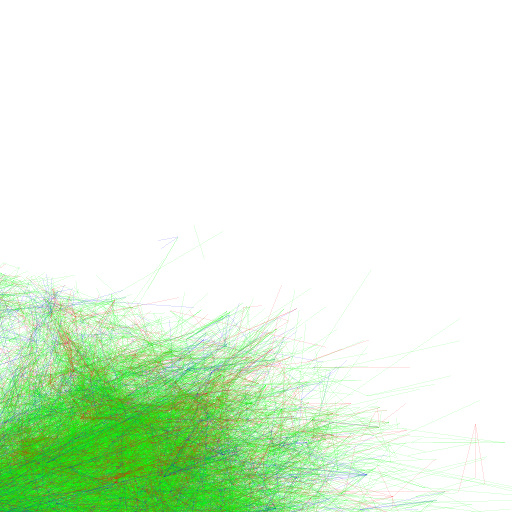

In [66]:
%%.render -n NBERPatents
#pragma gs attribute(float X[N])
#pragma gs attribute(float Y[N])
#pragma gs attribute(uint AppYear[N])
#pragma gs attribute(uint GotYear[N])
#pragma gs attribute(uint Cat1[N])
#pragma gs attribute(uint Cat2[N])

#pragma gs shader(positional)
void main() {
    float x = X[gs_NodeIndex];
    float y = Y[gs_NodeIndex];
    gs_NodePosition = vec3(x, y, 0);
}

#pragma gs shader(relational)
void main() {
}

#pragma gs shader(appearance)
void main() {
    #pragma gs define(SRC_CAT1 2)
    #pragma gs define(TGT_CAT1 4)
    #pragma gs define(LO 1980)
    #pragma gs define(HI 1989)

    #pragma gs scratch(uint Seen[E])
    bool first = 0 == atomicAdd(Seen[gs_EdgeIndex], 1);

    bool d = false;

    #pragma gs scratch(atomic_uint count)
    if (first) atomicCounterAdd(count, 1);

    if (Cat1[gs_SourceIndex] != SRC_CAT1) {
        d = true;
        #pragma gs scratch(atomic_uint wrong_source_cat)
        if (first) atomicCounterAdd(wrong_source_cat, 1);
    }

    if (Cat1[gs_TargetIndex] != TGT_CAT1) {
        d = true;
        #pragma gs scratch(atomic_uint wrong_target_cat)
        if (first) atomicCounterAdd(wrong_target_cat, 1);
    }

    if (AppYear[gs_SourceIndex] < LO) {
        d = true;
        #pragma gs scratch(atomic_uint app_year_too_lo)
        if (first) atomicCounterAdd(app_year_too_lo, 1);
    }

    if (AppYear[gs_SourceIndex] > HI) {
        d = true;
        #pragma gs scratch(atomic_uint app_year_too_hi)
        if (first) atomicCounterAdd(app_year_too_hi, 1);
    }

    if (d) {
        #pragma gs scratch(atomic_uint discarded)
        if (first) atomicCounterAdd(discarded, 1);
        discard;
    }

    #pragma gs scratch(atomic_uint kept)
    if (first) atomicCounterAdd(kept, 1);

    uint gotyear = GotYear[gs_SourceIndex];
    uint appyear = AppYear[gs_SourceIndex];
    uint lag = gotyear - appyear;

    #pragma gs define(CUTOFF1 2)
    #pragma gs define(CUTOFF2 4)

    gs_FragColor = vec4(0.1);
    gs_FragColor.r = int(lag < CUTOFF1);
    gs_FragColor.g = int(CUTOFF1 <= lag && lag < CUTOFF2);
    gs_FragColor.b = int(CUTOFF2 <= lag);
}


# end